# Generalities for DAEs and VAEs

* Import libraries
* Run on GPU if possible
* Create data loaders

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt

# create directory to save results
!mkdir results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print(f"using {device} device")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

mkdir: cannot create directory ‘results’: File exists
using cuda device


# Neural Network classes

* Deterministic auto-encoder (DAE)
* Variational auto-encoder (VAE)


In [ ]:
# Deterministic Auto-Encoder (DAE)
class DAE(nn.Module):

    # declare layers
    def __init__(self):
        super(DAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    # encoder: one ReLU hidden layer of 400 nodes, one Linear output layer of 20 nodes
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h)

    # decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    # forward: encoder followed by decoder
    def forward(self, x):
        z = self.encode(x.view(-1, 784))
        return self.decode(z)

# Variational Auto-Encoder (VAE)     
class VAE(nn.Module):

    # declare layers
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    # Encoder: one ReLU hidden layer of 400 nodes, two Linear output layers of 20 nodes (means and log_variances)
    # Input: image (array of size 784)
    # Output: means (array of size 20), log_variances (array of size 20)
    def encode(self, x):
        h = F.relu(self.fc1(x))
        means = self.fc2(h).to(device)
        log_variances = self.fc2(h).to(device)
        return means, log_variances

    # Reparameterization:
    #
    # Let eps be samples from a Normal(0,1)
    # Input: means (array of size 20), log_variances (array of size 20)
    # Output: embedding (array of size 20 corresponding to means + eps * exponential(log_variances/2))
    def reparameterize(self, means, log_variances):
        embedding = means + (torch.randn(means.shape[0], 20).to(device) * torch.exp(log_variances/2).to(device))
        embedding = embedding.to(device)
        return embedding

    # Decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    # Input: embedding (array of size 20)
    # Output: probability of reconstructed image (array of size 784)
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        probabilties = torch.sigmoid(self.fc4(h3)).to(device)
        return probabilties

    # Function forward: encoder, reparameterize, decoder
    # Input: image
    # Output: probability of reconstructed image, means, log_variances
    def forward(self, x):
        means, log_variances = self.encode(x.view(-1, 784))
        means = means.to(device)
        log_variances = log_variances.to(device)
        embedding = self.reparameterize(means, log_variances)
        probabilties = self.decode(embedding).to(device)
        return probabilties, means, log_variances

# Loss Functions

In [ ]:
# DAE Loss Function
# Reconstruction loss: binary cross entropy
#
# Inputs:
#    reconstructed_x: reconstructed image
#    x: image
#
# Output:
#    BCE: binary cross entropy  
#
def dae_loss_function(reconstructed_x, x):
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    return BCE

# VAE Loss Function
# Reconstruction loss: binary cross entropy
# KL divergence loss: -0.5 * sum(1 + log_variances - means^2 - exp(log_variances))
#       see Appendix B from VAE paper:
#       Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#       https://arxiv.org/abs/1312.6114
#
# Inputs: 
#    reconstructed_x: reconstructed image
#    x: image
#    means: array of size 20
#    log_variances: array of size 20
#
# Outputs:
#    total_loss: binary cross entropy + KL divergence (scalar)
#    BCE: binary cross entropy (scalar)
#
def vae_loss_function(reconstructed_x, x, means, log_variances):
   
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_variances - torch.square(means) - torch.exp(log_variances))
    total_loss = BCE + KLD
    return total_loss, BCE


# Training

In [ ]:
# DAE Training
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#    optimizer: DAE optimizer
#
# Outputs:
#    average_train_BCE: binary cross entropy (scalar)
#
def dae_train(epoch, model, optimizer):
    train_BCE = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = dae_loss_function(recon_batch, data)
        loss.backward()
        train_BCE += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    average_train_BCE = train_BCE / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, average_train_BCE))
    return average_train_BCE

# VAE Training
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#    optimizer: VAE optimizer
#
# Outputs:
#    average_train_loss: binary cross entropy + KL divergence (scalar)
#    average_train_BCE: binary cross entropy (scalar)
#
def vae_train(epoch, model, optimizer):
    
    train_loss = 0
    train_BCE = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        probabilties, means, log_variances = model(data)
        loss, BCE = vae_loss_function(probabilties, data, means, log_variances)
        loss.backward()
        train_loss += loss.item()
        train_BCE += BCE.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
            
    average_train_loss = train_loss / len(train_loader.dataset)
    average_train_BCE = train_BCE / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, average_train_loss))

    return average_train_loss, average_train_BCE



# Testing

In [ ]:
# DAE Test
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#
# Outputs:
#    average_test_BCE: binary cross entropy (scalar)
#
def dae_test(epoch, model):
    model.eval()
    test_BCE = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_BCE += dae_loss_function(recon_batch, data).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('results/reconstruction_' + str(epoch) + '.png'))

    average_test_BCE = test_BCE / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(average_test_BCE))
    return average_test_BCE

# VAE Test
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#
# Outputs:
#    average_test_loss: binary cross entropy + KL divergence (scalar)
#    average_test_BCE: binary cross entropy (scalar)
#
def vae_test(epoch, model):

    model.eval()
    test_loss = 0
    test_BCE = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            probabilties, means, log_variances = model(data)
            loss, BCE = vae_loss_function(probabilties, data, means, log_variances)
            test_loss += loss.item()
            test_BCE += BCE.item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n], probabilties.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison, 'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('results/reconstruction_' + str(epoch) + '.png'))

    average_test_loss = test_loss / len(test_loader.dataset)
    average_test_BCE = test_BCE / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(average_test_loss))

    return average_test_loss, average_test_BCE


# Main

Train Epoch: 1 [0/60000 (0%)]	Loss: 544.778015
Train Epoch: 1 [12800/60000 (21%)]	Loss: 149.261475
Train Epoch: 1 [25600/60000 (43%)]	Loss: 115.138870
Train Epoch: 1 [38400/60000 (64%)]	Loss: 101.938110
Train Epoch: 1 [51200/60000 (85%)]	Loss: 91.922134
====> Epoch: 1 Average loss: 129.3189
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


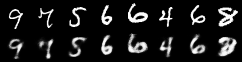

====> Test set loss: 87.7723
Sample of generated images


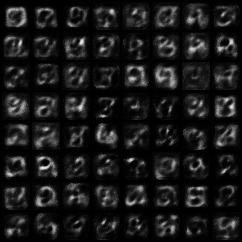



Train Epoch: 2 [0/60000 (0%)]	Loss: 88.063782
Train Epoch: 2 [12800/60000 (21%)]	Loss: 88.792068
Train Epoch: 2 [25600/60000 (43%)]	Loss: 81.067200
Train Epoch: 2 [38400/60000 (64%)]	Loss: 81.470230
Train Epoch: 2 [51200/60000 (85%)]	Loss: 78.676140
====> Epoch: 2 Average loss: 82.5305
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


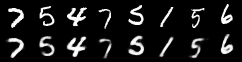

====> Test set loss: 79.0017
Sample of generated images


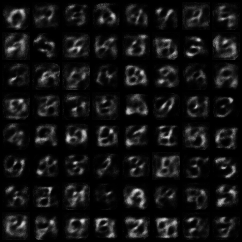



Train Epoch: 3 [0/60000 (0%)]	Loss: 76.326813
Train Epoch: 3 [12800/60000 (21%)]	Loss: 82.374962
Train Epoch: 3 [25600/60000 (43%)]	Loss: 74.677063
Train Epoch: 3 [38400/60000 (64%)]	Loss: 77.437683
Train Epoch: 3 [51200/60000 (85%)]	Loss: 76.944839
====> Epoch: 3 Average loss: 76.9604
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


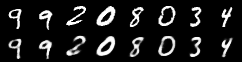

====> Test set loss: 74.8197
Sample of generated images


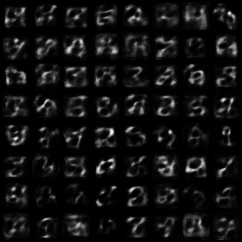



Train Epoch: 4 [0/60000 (0%)]	Loss: 76.641220
Train Epoch: 4 [12800/60000 (21%)]	Loss: 75.960991
Train Epoch: 4 [25600/60000 (43%)]	Loss: 76.324089
Train Epoch: 4 [38400/60000 (64%)]	Loss: 74.009193
Train Epoch: 4 [51200/60000 (85%)]	Loss: 71.818367
====> Epoch: 4 Average loss: 74.3036
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


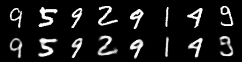

====> Test set loss: 72.6521
Sample of generated images


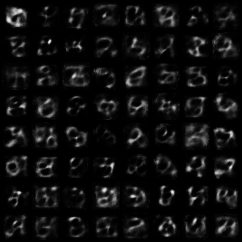



Train Epoch: 5 [0/60000 (0%)]	Loss: 72.999191
Train Epoch: 5 [12800/60000 (21%)]	Loss: 73.246140
Train Epoch: 5 [25600/60000 (43%)]	Loss: 74.238693
Train Epoch: 5 [38400/60000 (64%)]	Loss: 74.715607
Train Epoch: 5 [51200/60000 (85%)]	Loss: 70.649765
====> Epoch: 5 Average loss: 72.5441
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


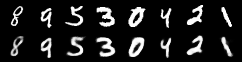

====> Test set loss: 71.3761
Sample of generated images


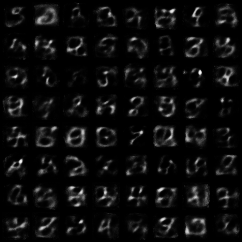



Train Epoch: 6 [0/60000 (0%)]	Loss: 70.534866
Train Epoch: 6 [12800/60000 (21%)]	Loss: 72.567596
Train Epoch: 6 [25600/60000 (43%)]	Loss: 72.920509
Train Epoch: 6 [38400/60000 (64%)]	Loss: 69.766693
Train Epoch: 6 [51200/60000 (85%)]	Loss: 69.304138
====> Epoch: 6 Average loss: 71.2910
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


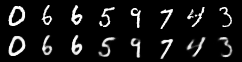

====> Test set loss: 70.5354
Sample of generated images


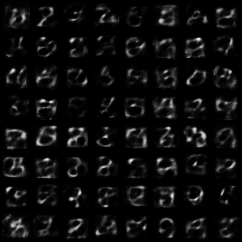



Train Epoch: 7 [0/60000 (0%)]	Loss: 67.520271
Train Epoch: 7 [12800/60000 (21%)]	Loss: 67.622063
Train Epoch: 7 [25600/60000 (43%)]	Loss: 71.399002
Train Epoch: 7 [38400/60000 (64%)]	Loss: 71.237305
Train Epoch: 7 [51200/60000 (85%)]	Loss: 70.296059
====> Epoch: 7 Average loss: 70.2968
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


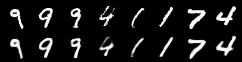

====> Test set loss: 69.6042
Sample of generated images


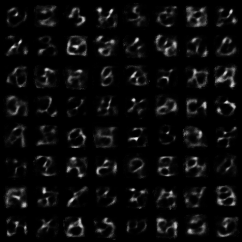



Train Epoch: 8 [0/60000 (0%)]	Loss: 66.645187
Train Epoch: 8 [12800/60000 (21%)]	Loss: 70.852585
Train Epoch: 8 [25600/60000 (43%)]	Loss: 72.938545
Train Epoch: 8 [38400/60000 (64%)]	Loss: 70.026253
Train Epoch: 8 [51200/60000 (85%)]	Loss: 70.162727
====> Epoch: 8 Average loss: 69.4868
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


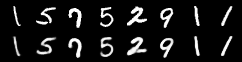

====> Test set loss: 68.9618
Sample of generated images


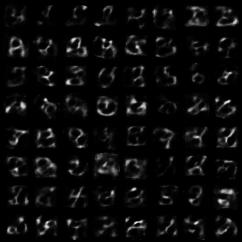



Train Epoch: 9 [0/60000 (0%)]	Loss: 70.184769
Train Epoch: 9 [12800/60000 (21%)]	Loss: 66.611351
Train Epoch: 9 [25600/60000 (43%)]	Loss: 68.121948
Train Epoch: 9 [38400/60000 (64%)]	Loss: 65.295151
Train Epoch: 9 [51200/60000 (85%)]	Loss: 67.569778
====> Epoch: 9 Average loss: 68.8377
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


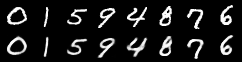

====> Test set loss: 68.4731
Sample of generated images


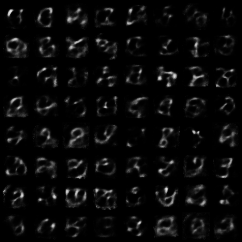



Train Epoch: 10 [0/60000 (0%)]	Loss: 67.376793
Train Epoch: 10 [12800/60000 (21%)]	Loss: 69.157059
Train Epoch: 10 [25600/60000 (43%)]	Loss: 66.472633
Train Epoch: 10 [38400/60000 (64%)]	Loss: 70.498161
Train Epoch: 10 [51200/60000 (85%)]	Loss: 69.976936
====> Epoch: 10 Average loss: 68.3043
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


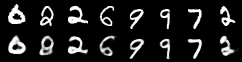

====> Test set loss: 68.0144
Sample of generated images


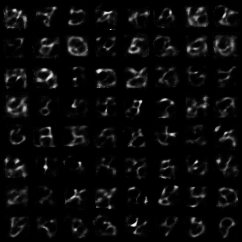

In [ ]:
# train and test DAE
epochs = 10
dae_average_train_BCE = []
dae_average_test_BCE = []
dae_model = DAE().to(device)
dae_optimizer = optim.Adam(dae_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    average_train_BCE = dae_train(epoch, dae_model, dae_optimizer)
    dae_average_train_BCE.append(average_train_BCE)
    average_test_BCE = dae_test(epoch, dae_model)
    dae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = dae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')


Train Epoch: 1 [0/60000 (0%)]	Loss: 549.390442
Train Epoch: 1 [12800/60000 (21%)]	Loss: 202.630890
Train Epoch: 1 [25600/60000 (43%)]	Loss: 164.512543
Train Epoch: 1 [38400/60000 (64%)]	Loss: 159.703186
Train Epoch: 1 [51200/60000 (85%)]	Loss: 156.376541
====> Epoch: 1 Average loss: 179.4556
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


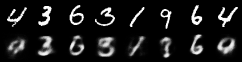

====> Test set loss: 151.6409
Sample of generated images


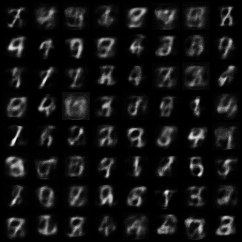



Train Epoch: 2 [0/60000 (0%)]	Loss: 153.464783
Train Epoch: 2 [12800/60000 (21%)]	Loss: 144.526566
Train Epoch: 2 [25600/60000 (43%)]	Loss: 146.699646
Train Epoch: 2 [38400/60000 (64%)]	Loss: 147.041931
Train Epoch: 2 [51200/60000 (85%)]	Loss: 143.586761
====> Epoch: 2 Average loss: 147.0067
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


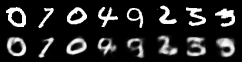

====> Test set loss: 142.6178
Sample of generated images


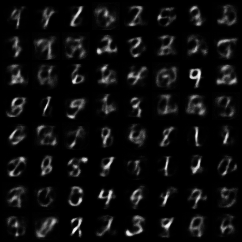



Train Epoch: 3 [0/60000 (0%)]	Loss: 142.676758
Train Epoch: 3 [12800/60000 (21%)]	Loss: 139.875244
Train Epoch: 3 [25600/60000 (43%)]	Loss: 139.716187
Train Epoch: 3 [38400/60000 (64%)]	Loss: 140.896027
Train Epoch: 3 [51200/60000 (85%)]	Loss: 139.687225
====> Epoch: 3 Average loss: 141.2734
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


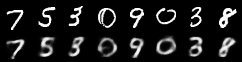

====> Test set loss: 138.8140
Sample of generated images


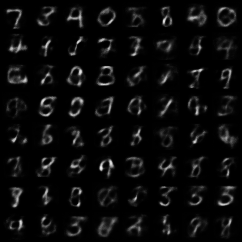



Train Epoch: 4 [0/60000 (0%)]	Loss: 139.805023
Train Epoch: 4 [12800/60000 (21%)]	Loss: 141.902817
Train Epoch: 4 [25600/60000 (43%)]	Loss: 141.740082
Train Epoch: 4 [38400/60000 (64%)]	Loss: 139.731125
Train Epoch: 4 [51200/60000 (85%)]	Loss: 137.738327
====> Epoch: 4 Average loss: 138.3259
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


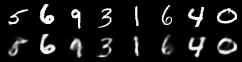

====> Test set loss: 136.9051
Sample of generated images


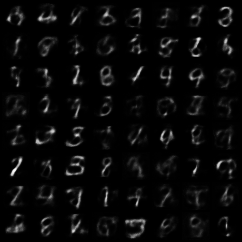



Train Epoch: 5 [0/60000 (0%)]	Loss: 132.239929
Train Epoch: 5 [12800/60000 (21%)]	Loss: 137.066101
Train Epoch: 5 [25600/60000 (43%)]	Loss: 143.175552
Train Epoch: 5 [38400/60000 (64%)]	Loss: 136.278625
Train Epoch: 5 [51200/60000 (85%)]	Loss: 142.025116
====> Epoch: 5 Average loss: 136.7190
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


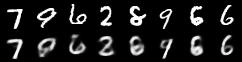

====> Test set loss: 135.2882
Sample of generated images


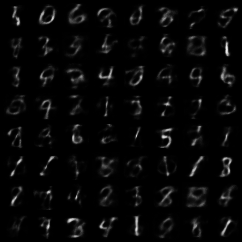



Train Epoch: 6 [0/60000 (0%)]	Loss: 127.007835
Train Epoch: 6 [12800/60000 (21%)]	Loss: 137.135422
Train Epoch: 6 [25600/60000 (43%)]	Loss: 127.319450
Train Epoch: 6 [38400/60000 (64%)]	Loss: 132.648331
Train Epoch: 6 [51200/60000 (85%)]	Loss: 134.760254
====> Epoch: 6 Average loss: 135.4706
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


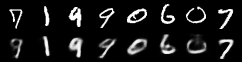

====> Test set loss: 134.1555
Sample of generated images


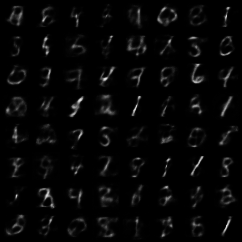



Train Epoch: 7 [0/60000 (0%)]	Loss: 129.055435
Train Epoch: 7 [12800/60000 (21%)]	Loss: 132.258255
Train Epoch: 7 [25600/60000 (43%)]	Loss: 131.551086
Train Epoch: 7 [38400/60000 (64%)]	Loss: 136.285355
Train Epoch: 7 [51200/60000 (85%)]	Loss: 133.112518
====> Epoch: 7 Average loss: 134.4767
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


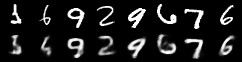

====> Test set loss: 133.5888
Sample of generated images


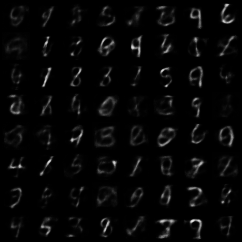



Train Epoch: 8 [0/60000 (0%)]	Loss: 128.600891
Train Epoch: 8 [12800/60000 (21%)]	Loss: 136.016037
Train Epoch: 8 [25600/60000 (43%)]	Loss: 132.410736
Train Epoch: 8 [38400/60000 (64%)]	Loss: 131.003677
Train Epoch: 8 [51200/60000 (85%)]	Loss: 142.347549
====> Epoch: 8 Average loss: 133.7213
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


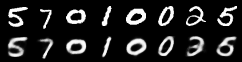

====> Test set loss: 132.8028
Sample of generated images


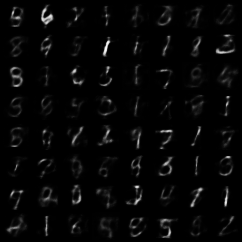



Train Epoch: 9 [0/60000 (0%)]	Loss: 135.112961
Train Epoch: 9 [12800/60000 (21%)]	Loss: 130.642120
Train Epoch: 9 [25600/60000 (43%)]	Loss: 136.791016
Train Epoch: 9 [38400/60000 (64%)]	Loss: 132.194183
Train Epoch: 9 [51200/60000 (85%)]	Loss: 132.350586
====> Epoch: 9 Average loss: 133.1263
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


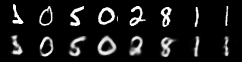

====> Test set loss: 132.0387
Sample of generated images


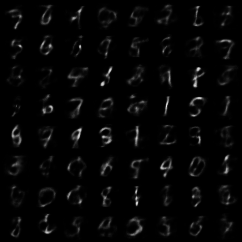



Train Epoch: 10 [0/60000 (0%)]	Loss: 134.408203
Train Epoch: 10 [12800/60000 (21%)]	Loss: 126.122879
Train Epoch: 10 [25600/60000 (43%)]	Loss: 130.480850
Train Epoch: 10 [38400/60000 (64%)]	Loss: 129.409729
Train Epoch: 10 [51200/60000 (85%)]	Loss: 132.668365
====> Epoch: 10 Average loss: 132.6963
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


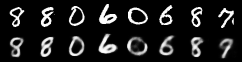

====> Test set loss: 131.8374
Sample of generated images


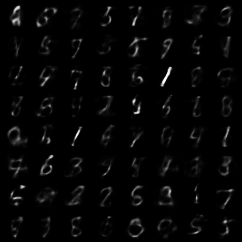

In [ ]:
# train and test VAE
epochs = 10
vae_average_train_losses = []
vae_average_train_BCE = []

vae_average_test_losses = []
vae_average_test_BCE = []

vae_model = VAE().to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

for epoch in range(1, epochs + 1):

    average_train_loss, average_train_BCE = vae_train(epoch, vae_model, vae_optimizer)
    vae_average_train_losses.append(average_train_loss)
    vae_average_train_BCE.append(average_train_BCE)

    average_test_loss, average_test_BCE = vae_test(epoch, vae_model)
    vae_average_test_losses.append(average_test_loss)
    vae_average_test_BCE.append(average_test_BCE)
    
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = vae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

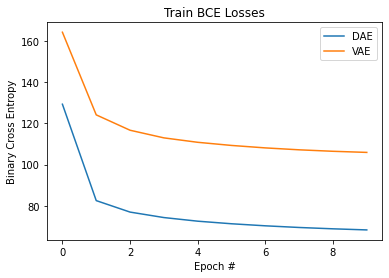

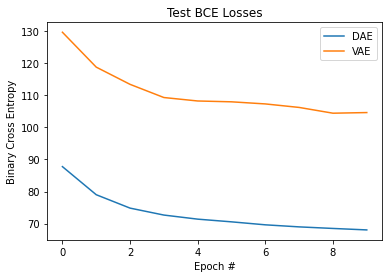

In [ ]:
# Plot Train BCE Losses
plt.plot(dae_average_train_BCE)
plt.plot(vae_average_train_BCE)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

# Plot Test BCE Losses
plt.plot(dae_average_test_BCE)
plt.plot(vae_average_test_BCE)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

## Explanation of the results:
- Although train and test dataset binary cross entropy losses are higher for VAE compared to that of DAE, the reconstructed images for the test dataset is much more better and recognisable as digits in case of VAE then that from DAE trained model.
- The reason for this could be understood as VAE uses random noise as per some probability distribution in its latent space or hidden layer, whereas DAE just compress the input images in its latent space determinstically. This results into DAE giving good reconstruction of train dataset images compared to VAE, but it fails to reconstruct test dataset images, because it overfits on the train dataset images, and the model weights parameters are not capable to contruct good images from test dataset.
- And when we use VAE, we also make sure that model does not overfit on the train dataset by adding a KL divergence regularization term in its loss function. This necessaitates the model to add random noise in the latent space matching to gaussian distribution or some other predefined probability distribution. Therefore, everytime we train the model, this makes weights or model parameters learnt with VAE more robust and less prone to overfitting, and therefore we are still able to create realistic digits images even from the unseen test dataset images. 